<div style = "text-align:center; font-size: 28px; font-weight: bold;"> Predictive Service Delay Management for CTA Trains</div>
<br>


This notebook reflects the necessary steps taken to arrive at a functioning predictive model to predict delays for commuting trains in Chicago.

Business Problem: Chicago has the second-largest transit system in the United States, and yet, it is still plagued with constant delays. 

Understanding the Data Source: The dataset was fetched via script from two APIs, the CTA Train Tracker API, and TomTom's Traffic Flow RESTful API.

Data Limitations: There was no access to historical data for this project, and also no access to a cloud server where it was possible to run the script 24/7 to collect data for every hour.


### Installing and Import Necessary Libraries

In [1]:
pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in c:\users\simon\anaconda3\envs\learn-env\lib\site-packages (1.3.0)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in c:\users\simon\anaconda3\envs\learn-env\lib\site-packages (0.11.0)
Note: you may need to restart the kernel to use updated packages.


In [53]:
pip install torch

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE


### Import the Dataset

The dataset is based on real-time data, and is sourced from two separate APIs, the CTA Train Tracker API, and TomTom's Traffic Flow RESTful API.

In [4]:
# The dataset has no column headers, so we are applying column labels based on the API script used to scrape the data
column_labels = [
    "station_id", "line", "predicted_time", "arrival_time", 
    "isSch", "isFlt", "isDly", 
    "station_name", "destination_name", "lat", "long", 
    "free_flow_speed", "current_speed"
]

df = pd.read_csv("combined_data.csv", header = None, names = column_labels)

In [5]:
df.sample(n = 5)

,station_id,line,predicted_time,arrival_time,isSch,isFlt,isDly,station_name,destination_name,lat,long,free_flow_speed,current_speed
40191,40440,Pink,20230811 01:57:21,20230811 01:58:21,0,0,0,California,54th/Cermak,41.85439,-87.68775,25,25
100274,41120,G,20230819 18:12:57,20230819 18:29:57,0,0,0,35th-Bronzeville-IIT,Harlem/Lake,41.77895,-87.66377,26,21
83367,40670,Blue,20230815 19:21:33,20230815 19:29:33,0,0,0,Western (O'Hare Branch),O'Hare,41.88571,-87.63703,8,6
35917,40370,Blue,20230810 20:51:29,20230810 21:19:29,0,0,0,Washington,Forest Park,41.88316,-87.62944,13,13
4741,40210,Pink,20230810 13:41:07,20230810 13:56:07,0,0,0,Damen,54th/Cermak,41.87872,-87.63374,14,14


Some of these column headers may be hard to decipher. Let's clarify what they mean.

Per the CTA Train Tracker API:

**predicted_time** = "Date-time format stamp for when the prediction was generated:
yyyyMMdd HH:mm:ss (24-hour format, time local to Chicago)"

**arrival_time** = "Date-time format stamp for when a train is expected to arrive/depart:
yyyyMMdd HH:mm:ss (24-hour format, time local to Chicago)"

**isSch** = "Boolean flag to indicate whether this is a live prediction or based on
schedule in lieu of live data"

**isFlt** = "Boolean flag to indicate whether a potential fault has been detected"

>"The **isFlt** element in the results indicates what we call a “schedule fault” in the context of Train Tracker.
A fault on an ETA that is schedule-based (isSch=1) indicates that the scheduled arrival time given
might not be feasible to serve due to the lack of a scheduled departure having occurred."

**isDly** = "Boolean flag to indicate whether a train is considered “delayed” in Train
Tracker"

**lat** = "Latitude position of the train in decimal degrees"

**long** = "Longitude position of the train in decimal degrees"

Per TomTom's Traffic Flow RESTful API:

**free_flow_speed** = "The free flow speed expected under ideal conditions, expressed in [MPH]

**current_speed** = "The current average speed at the selected [latitude and longitude], in [MPH]."

>Note that these speeds fetched from the TomTom API *do not* directly refer to the train itself; they are not train speeds. Rather, they are referring to the *traffic speeds* of the roads closest to the geographical coordinates of the specifc train.

<div style = "text-align:center; font-size: 24px; font-weight: bold;"> Exploratory Data Analysis (EDA)</div>


### The Basics

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114230 entries, 0 to 114229
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   station_id        114230 non-null  int64  
 1   line              114230 non-null  object 
 2   predicted_time    114230 non-null  object 
 3   arrival_time      114230 non-null  object 
 4   isSch             114230 non-null  int64  
 5   isFlt             114230 non-null  int64  
 6   isDly             114230 non-null  int64  
 7   station_name      114230 non-null  object 
 8   destination_name  114230 non-null  object 
 9   lat               114230 non-null  float64
 10  long              114230 non-null  float64
 11  free_flow_speed   114230 non-null  int64  
 12  current_speed     114230 non-null  int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 11.3+ MB


In [7]:
top_stations = df['station_id'].value_counts().nlargest(20)

bottom_stations = df['station_id'].value_counts().nsmallest(20)

print("Most frequent stations in this dataset:", top_stations, sep="\n\n")

print(" ")

print("Least frequent stations in this dataset:", bottom_stations, sep="\n\n")

Most frequent stations in this dataset:

40040    1949
40260    1870
40160    1857
40170    1703
40380    1602
40080    1511
40190    1493
40330    1462
40680    1452
40460    1406
40730    1378
40850    1290
40090    1288
40240    1278
40120    1248
40530    1236
40100    1236
40210    1234
40150    1233
40030    1196
Name: station_id, dtype: int64
 
Least frequent stations in this dataset:

40810      1
41680     29
41380     64
40140    127
41250    272
40920    283
41050    287
40980    291
40970    292
41140    300
40840    347
40690    350
40720    367
40520    380
40940    381
40390    410
40400    425
40900    434
40250    447
40180    450
Name: station_id, dtype: int64


### Delays

From the points of clarity earlier, we can make several observations.
First, let's see how many **already-classified delays** there are in this dataset.

In [8]:
df['isDly'].value_counts()

0    113665
1       565
Name: isDly, dtype: int64

Out of **110699** total train-tracking instances in this dataset, only **555** of them are **delay-positive**. 

Per the CTA Train Tracker API documentation:

>"The CTA Train Tracker service looks at how long it’s been since a train has moved from one track
circuit to the next and identifies delays if a train appears to not be moving."

Next, let's see how many instances are based on schedule or have a potential fault. 

In [9]:
df['isSch'].value_counts()

0    114230
Name: isSch, dtype: int64

In [10]:
df['isFlt'].value_counts()

0    114230
Name: isFlt, dtype: int64

Out of the entire dataset, every train so far is based on live predictions and has not had a fault. 

<div style = "text-align:left; font-size: 18px; font-weight: normal;"> Now, let's return to delays, and analyze them further. Let's see how many recorded delays there are for every specific line.  </div>

>For those who are not native to Chicago, the city's train system consists of multiple colored lines, each of which is associated with a color name. 

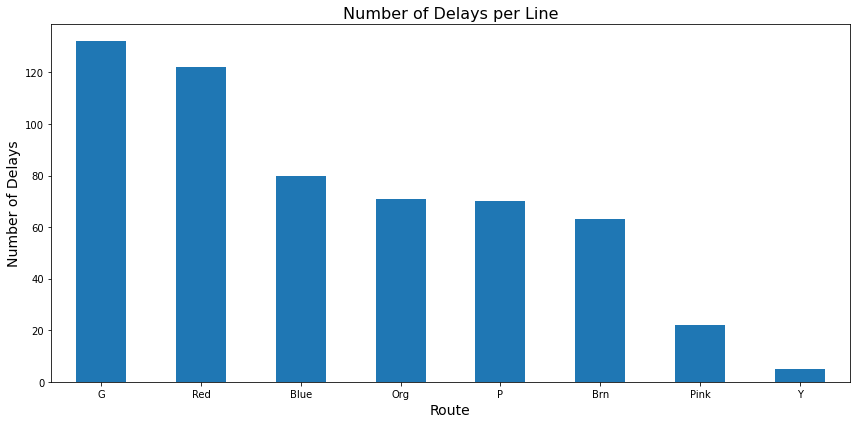

In [11]:
route_delay_counts = df.groupby('line')['isDly'].sum()
sorted_route_delay_counts = route_delay_counts.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sorted_route_delay_counts.plot(kind='bar')
plt.xlabel('Route', fontsize=14)  # Increase x-label font size
plt.ylabel('Number of Delays', fontsize=14)  # Increase y-label font size
plt.title('Number of Delays per Line', fontsize=16)  # Increase title font size
plt.xticks(rotation=0)
plt.grid(False)
plt.tight_layout()
plt.show()



It seems the Green Line (G) has the most delays out of all the lines. 

<div style = "text-align:left; font-size: 18px; font-weight: normal;"> Now let's analyze delays per station. </div>

Station ID with the most delays: 40100
Delay count: 13


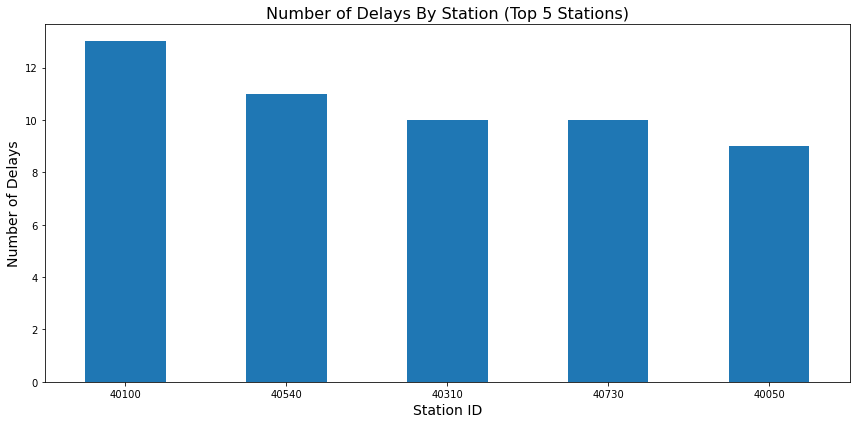

In [12]:
# Calculate the station with the most delays
station_delay_counts = df.groupby('station_id')['isDly'].sum()
most_delay_station = station_delay_counts.idxmax()
most_delay_count = station_delay_counts.loc[most_delay_station]

print("Station ID with the most delays:", most_delay_station)
print("Delay count:", most_delay_count)

# Define the number of top stations to display
top_n = 5
top_delay_stations = station_delay_counts.nlargest(top_n).index

# Create the bar plot
plt.figure(figsize=(12, 6))
station_delay_counts.loc[top_delay_stations].plot(kind='bar', stacked=True)
plt.xlabel('Station ID', fontsize=14)  # Increase x-label font size
plt.ylabel('Number of Delays', fontsize=14)  # Increase y-label font size
plt.title(f"Number of Delays By Station (Top {top_n} Stations)", fontsize=16)  # Increase title font size
plt.xticks(rotation = 0)
plt.grid(False)
plt.tight_layout()
plt.show()


<div style = "text-align:left; font-size: 18px; font-weight: normal;"> Now let's look at delays per hour. </div>

In [13]:
# Convert 'predicted_time' to datetime
df['predicted_time'] = pd.to_datetime(df['predicted_time'])

# Create a list of all hours (0 to 23)
all_hours = list(range(24))

# Create a DataFrame with all hours
hourly_delays = pd.DataFrame({'hour_of_day': all_hours})

# Merge the original data with the all hours DataFrame to count delays for each hour
hourly_delays = hourly_delays.merge(df.groupby(df['predicted_time'].dt.hour)['isDly'].sum().reset_index(), 
                                    how = 'left', left_on = 'hour_of_day', right_on = 'predicted_time')

# Fill NaN values with 0 (no delays)
hourly_delays['isDly'] = hourly_delays['isDly'].fillna(0).astype(int)

# Drop the redundant 'predicted_time' column
hourly_delays.drop(columns=['predicted_time'], inplace = True)

# Rename columns
hourly_delays.columns = ['hour_of_day', 'number_of_delays']

# Print the new DataFrame
hourly_delays

,hour_of_day,number_of_delays
0,0,21
1,1,27
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0


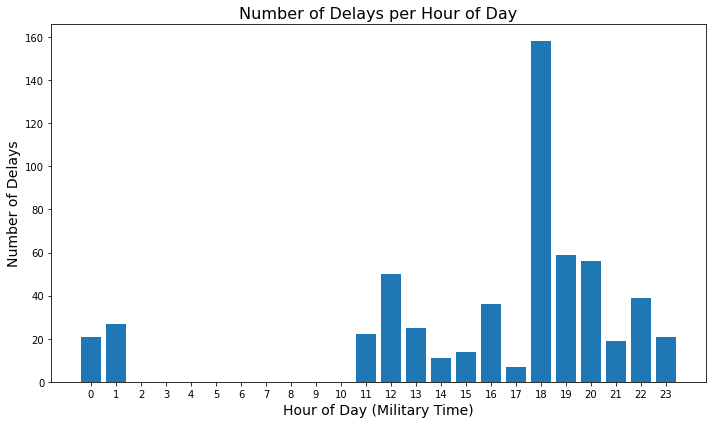

In [14]:
plt.figure(figsize=(10, 6))
plt.bar(hourly_delays['hour_of_day'], hourly_delays['number_of_delays'])
plt.xlabel('Hour of Day (Military Time)', fontsize=14)  # Increase x-label font size
plt.ylabel('Number of Delays', fontsize=14)  # Increase y-label font size
plt.title('Number of Delays per Hour of Day', fontsize=16)  # Increase title font size
plt.xticks(all_hours)
plt.grid(False)
plt.tight_layout()
plt.show()


It seems 6 pm is when delays are most frequent.

<div style="text-align:center; font-size: 24px; font-weight: bold;"> Data Preprocessing </div>
<br style="line-height: 3px;">
<div style="text-align:center; font-size: 18px; font-weight: bold;"> Feature Engineering (Wait Times and Lateness) </div>

To gain further insight into the characteristics of train delays, we can **engineer new columns** that can potentially enhance the predictive power of our machine learning model.

For instance, logically, the difference between **the time a particular prediction is generated** for when a train would arrive ('predicted_time' column), and **the time for when the train is predicted to arrive** ('arrival_time'), can be understood as time an individual would have to wait until the train arrives onto the platform, otherwise known as the **wait time**.

However, recall that, from the CTA Train Tracker API documentation:

>"The CTA Train Tracker service looks at how long it’s been since a train has moved from one track circuit to the next and identifies delays if a train appears to not be moving."

IMPORTANT: In this way, you can understand "delayed" trains as a *technical indicator*, where the train is at a standstill, and "late" trains as a *time-based indicator*, meaning that the train is traveling, but just from farther away.

With that being said, let's make a new column for how long the wait will be. We can call this new column, "wait_minutes".

In [15]:
# Convert 'predicted_time' and 'arrival_time' columns to datetime
df['predicted_time'] = pd.to_datetime(df['predicted_time'])
df['arrival_time'] = pd.to_datetime(df['arrival_time'])

# Calculate the difference between 'arrival_time' and 'predicted_time' in minutes
df['wait_minutes'] = (df['arrival_time'] - df['predicted_time']).dt.total_seconds() / 60

# Get the list of column names from the DataFrame
column_names = df.columns.tolist()

# Find the index of 'arrival_time'
arrival_time_index = column_names.index('arrival_time')

# Move 'wait_minutes' right after 'arrival_time'
column_names.insert(arrival_time_index + 1, column_names.pop(column_names.index('wait_minutes')))

# Reorder the DataFrame columns
df = df[column_names]

df.sample(n = 5)

,station_id,line,predicted_time,arrival_time,wait_minutes,isSch,isFlt,isDly,station_name,destination_name,lat,long,free_flow_speed,current_speed
107473,40880,Red,2023-08-20 18:59:28,2023-08-20 19:19:28,20.0,0,0,0,Thorndale,Howard,41.91709,-87.65261,19,19
67003,41120,G,2023-08-11 21:23:19,2023-08-11 21:25:19,2.0,0,0,0,35th-Bronzeville-IIT,Harlem/Lake,41.82366,-87.62569,16,12
52560,40260,Org,2023-08-11 15:03:30,2023-08-11 15:09:30,6.0,0,0,0,State/Lake,Midway,41.87695,-87.63365,17,17
107915,41170,Red,2023-08-20 19:06:36,2023-08-20 19:08:36,2.0,0,0,0,Garfield,95th/Dan Ryan,41.81227,-87.63021,70,70
65096,41380,Red,2023-08-11 20:58:13,2023-08-11 20:59:13,1.0,0,0,0,Bryn Mawr,95th/Dan Ryan,41.98350,-87.65884,12,7


Now, we have the wait time (in minutes) for every instance of a train-arrival prediction. Next, let's get the **average wait time for every train station**, and name the column 'station_avg_wait'.

In [16]:
# Group the data by 'station_id' and calculate the average delay time for each station
df['station_avg_wait'] = df.groupby('station_id')['wait_minutes'].transform('mean')

# Get the list of column names from the DataFrame
column_names = df.columns.tolist()

# Find the index of 'wait_minutes'
wait_minutes_index = column_names.index('wait_minutes')

# Move 'station_avg_wait' right after 'wait_minutes'
column_names.insert(wait_minutes_index + 1, column_names.pop(column_names.index('station_avg_wait')))

# Reorder the DataFrame columns
df = df[column_names]

df.sample(n = 5)

,station_id,line,predicted_time,arrival_time,wait_minutes,station_avg_wait,isSch,isFlt,isDly,station_name,destination_name,lat,long,free_flow_speed,current_speed
89548,40760,Red,2023-08-17 18:45:44,2023-08-17 18:50:44,5.0,21.578108,0,0,0,Granville,95th/Dan Ryan,42.01906,-87.67289,16,16
91563,40450,Red,2023-08-17 19:02:10,2023-08-17 19:29:10,27.0,21.452498,0,0,0,95th/Dan Ryan,95th/Dan Ryan,41.88481,-87.62781,10,7
51836,40830,Pink,2023-08-11 14:57:30,2023-08-11 15:12:30,15.0,19.027027,0,0,0,18th,54th/Cermak,41.87695,-87.63365,17,17
85889,40450,Red,2023-08-15 22:59:31,2023-08-15 23:15:31,16.0,21.452498,0,0,0,95th/Dan Ryan,95th/Dan Ryan,41.83119,-87.63064,67,67
33466,40170,G,2023-08-10 20:26:38,2023-08-10 20:53:38,27.0,10.745156,0,0,0,Ashland,Harlem/Lake,41.81646,-87.61904,19,19


Awesome. Now we have the wait time of every individual train-arrival prediction, compared to the average wait time for train-arrival predictions in the corresponding train stations. 

Below is a visual of this comparison for any station of interest. Simply run the cell and provide an station ID input.

List of unique station IDs:
[40260 40380 41700 40680 40850 40160 40040 40730 40460 40330 41400 41160
 41220 41120 41320 40820 40960 41020 40910 40740 40310 40670 40220 41480
 41080 41230 41130 41000 41690 41450 40710 40490 41060 40190 40170 40320
 40660 40830 40210 40120 40590 40530 41070 41040 41150 41170 40510 40250
 40540 41500 40150 40030 40550 40880 40240 40070 40560 40010 40020 40050
 40060 40080 40090 40100 40130 40180 40230 40270 40280 40290 40300 40360
 40370 40390 40400 40420 40440 40450 40480 40520 40570 40580 40600 40610
 40630 40650 40690 40700 40720 40750 40760 40780 40790 40800 40840 40870
 40890 40900 40920 40930 40940 40970 40980 40990 41010 41030 41050 41090
 41140 41180 41190 41200 41210 41240 41250 41260 41270 41280 41290 41300
 41310 41330 41350 41360 41380 41410 41420 41430 41440 41460 41490 41510
 41660 41670 40140 41680 40810]

Enter a station ID from the selection above to plot its 'wait_minutes' distribution: 41660


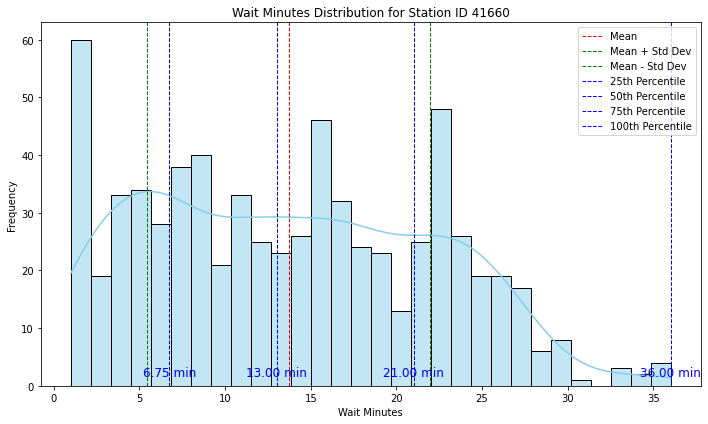

Average wait time: 13.70 minutes
Standard deviation of wait time: 8.27 minutes


In [17]:
# Get the list of unique station IDs
unique_stations = df['station_id'].unique()

print("List of unique station IDs:")
print(unique_stations)

# Prompt the user to input a station ID
station_id_input = int(input("\nEnter a station ID from the selection above to plot its 'wait_minutes' distribution: "))

# Filter the DataFrame for the selected station ID
selected_station_df = df[df['station_id'] == station_id_input]

# Calculate mean and standard deviation of wait_minutes for the selected station
mean_wait = selected_station_df['wait_minutes'].mean()
std_wait = selected_station_df['wait_minutes'].std()

# Calculate percentiles
percentiles = [25, 50, 75, 100]
percentile_values = np.percentile(selected_station_df['wait_minutes'], percentiles)

# Create the distribution plot using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=selected_station_df, x='wait_minutes', bins=30, kde=True, color = 'skyblue')
plt.axvline(mean_wait, color='r', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(mean_wait + std_wait, color='g', linestyle='dashed', linewidth=1, label='Mean + Std Dev')
plt.axvline(mean_wait - std_wait, color='g', linestyle='dashed', linewidth=1, label='Mean - Std Dev')

# Add percentile indicators
for p, value in zip(percentiles, percentile_values):
    plt.axvline(value, color='b', linestyle='dashed', linewidth=1, label=f'{p}th Percentile')
    plt.annotate(f'{value:.2f} min', (value, 0), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color='b')

plt.xlabel('Wait Minutes')
plt.ylabel('Frequency')
plt.title(f'Wait Minutes Distribution for Station ID {station_id_input}')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Average wait time: {mean_wait:.2f} minutes")
print(f"Standard deviation of wait time: {std_wait:.2f} minutes")

The logic follows that, any instance that has a wait time above the 75th percentile of all recorded wait times of the corresponding train station can be classified as a "**late**" train.
>The 75th percentile of wait times, calculated for each station, serves as a robust threshold for identifying lateness. By using the 75th percentile, we capture instances where the wait time is higher than most occurrences.This approach accounts for variations in station-specific wait time distributions and avoids being overly sensitive to outliers or temporary fluctuations.

So, we will make a new column called 'isLte' to indicate whether a train is late or not.

In [18]:
# Calculate the 75th percentile of wait_minutes for each station
station_75th_percentile = df.groupby('station_id')['wait_minutes'].quantile(0.75)

# Create a new column 'isLte' based on whether wait_minutes is above the 75th percentile
df['isLte'] = df.apply(lambda row: int(row['wait_minutes'] >= station_75th_percentile[row['station_id']]), axis=1)

# Get the list of column names from the DataFrame
column_names = df.columns.tolist()

# Find the index of 'station_avg_wait'
SAW_index = column_names.index('station_avg_wait')

# Move 'isLte' right after 'station_avg_wait'
column_names.insert(SAW_index + 1, column_names.pop(column_names.index('isLte')))

# Reorder the DataFrame columns
df = df[column_names]

df.sample(n = 5)

,station_id,line,predicted_time,arrival_time,wait_minutes,station_avg_wait,isLte,isSch,isFlt,isDly,station_name,destination_name,lat,long,free_flow_speed,current_speed
58282,40630,Red,2023-08-11 19:07:57,2023-08-11 19:22:57,15.0,13.390359,0,0,0,0,Clark/Division,95th/Dan Ryan,41.90392,-87.63141,7,7
59667,40560,Red,2023-08-11 19:17:09,2023-08-11 19:31:09,14.0,13.623457,0,0,0,0,Jackson,95th/Dan Ryan,41.92916,-87.65298,17,15
69015,40180,Blue,2023-08-11 22:35:37,2023-08-11 22:44:37,9.0,8.780000,0,0,0,0,Oak Park,Forest Park,41.87381,-87.73222,63,63
16455,40570,Blue,2023-08-10 16:33:16,2023-08-10 16:50:16,17.0,11.677419,1,0,0,0,California,Forest Park,41.92194,-87.69689,17,14
62038,41690,G,2023-08-11 19:38:39,2023-08-11 19:44:39,6.0,15.962712,0,0,0,0,Cermak-McCormick Place,Harlem/Lake,41.82134,-87.61916,21,16


Let's fully analyze late trains in this dataset, in the same way we did with delays.

In [19]:
df['isLte'].value_counts()

0    84321
1    29909
Name: isLte, dtype: int64

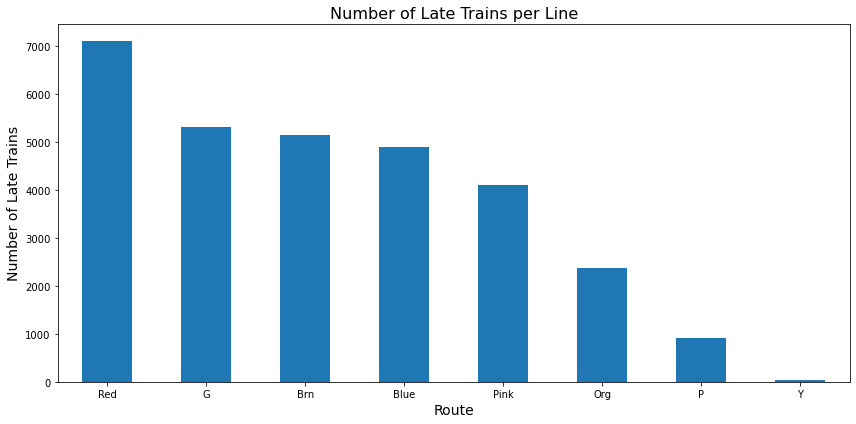

In [20]:
route_late_counts = df.groupby('line')['isLte'].sum()
sorted_route_late_counts = route_late_counts.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sorted_route_late_counts.plot(kind='bar')
plt.xlabel('Route', fontsize=14)  # Increase x-label font size
plt.ylabel('Number of Late Trains', fontsize=14)  # Increase y-label font size
plt.title('Number of Late Trains per Line', fontsize=16)  # Increase title font size
plt.xticks(rotation=0)
plt.grid(False)  # Disable grid lines
plt.tight_layout()
plt.show()


Station ID with the most late trains: 40040
Late train count: 542


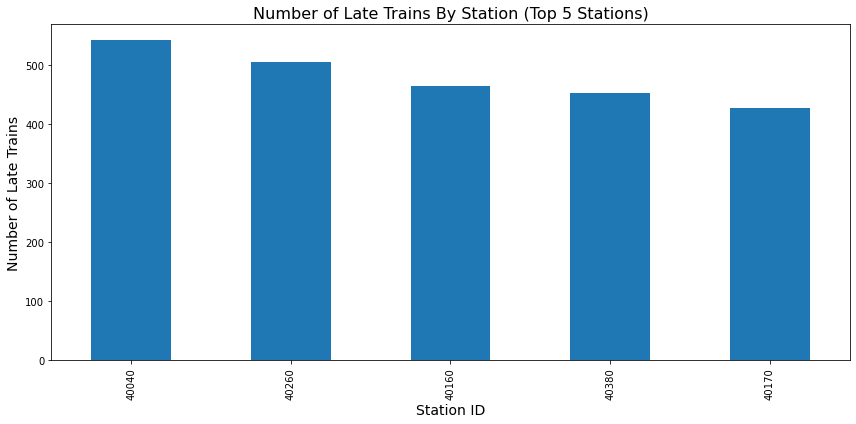

In [21]:
# Group the data by 'station_id' and calculate the sum of 'isLte' for each station
station_late_counts = df.groupby('station_id')['isLte'].sum()

# Find the station with the most late trains
most_late_station = station_late_counts.idxmax()
most_late_count = station_late_counts.loc[most_late_station]

print("Station ID with the most late trains:", most_late_station)
print("Late train count:", most_late_count)

# Get the top N stations with the most late trains
top_n = 5
top_late_stations = station_late_counts.nlargest(top_n).index

# Create a bar plot to visualize the number of late trains by station
plt.figure(figsize=(12, 6))
station_late_counts.loc[top_late_stations].plot(kind='bar', stacked=True)
plt.xlabel('Station ID', fontsize=14)  # Increase x-label font size
plt.ylabel('Number of Late Trains', fontsize=14)  # Increase y-label font size
plt.title(f"Number of Late Trains By Station (Top {top_n} Stations)", fontsize=16)  # Increase title font size
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(False)  # Enable grid lines
plt.show()


In [22]:
# Convert 'predicted_time' to datetime
df['predicted_time'] = pd.to_datetime(df['predicted_time'])

# Create a list of all hours (0 to 23)
all_hours = list(range(24))

# Create a DataFrame with all hours
hourly_lates = pd.DataFrame({'hour_of_day': all_hours})

# Merge the original data with the all hours DataFrame to count late trains for each hour
hourly_lates = hourly_lates.merge(df.groupby(df['predicted_time'].dt.hour)['isLte'].sum().reset_index(), 
                                  how='left', left_on='hour_of_day', right_on='predicted_time')

# Fill NaN values with 0 (no late trains)
hourly_lates['isLte'] = hourly_lates['isLte'].fillna(0).astype(int)

# Drop the redundant 'predicted_time' column
hourly_lates.drop(columns=['predicted_time'], inplace=True)

# Rename columns
hourly_lates.columns = ['hour_of_day', 'number_of_late_trains']

# Print the new DataFrame
hourly_lates


,hour_of_day,number_of_late_trains
0,0,1010
1,1,997
2,2,152
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0


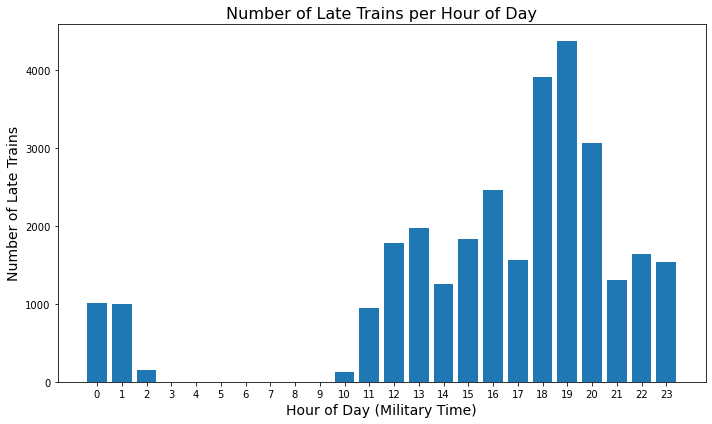

In [23]:
plt.figure(figsize=(10, 6))
plt.bar(hourly_lates['hour_of_day'], hourly_lates['number_of_late_trains'])
plt.xlabel('Hour of Day (Military Time)', fontsize=14)  # Increase x-label font size
plt.ylabel('Number of Late Trains', fontsize=14)  # Increase y-label font size
plt.title('Number of Late Trains per Hour of Day', fontsize=16)  # Increase title font size
plt.xticks(all_hours)
plt.grid(False)
plt.tight_layout()
plt.show()

Let's see how many instances of late trains correspond to actual delayed trains.

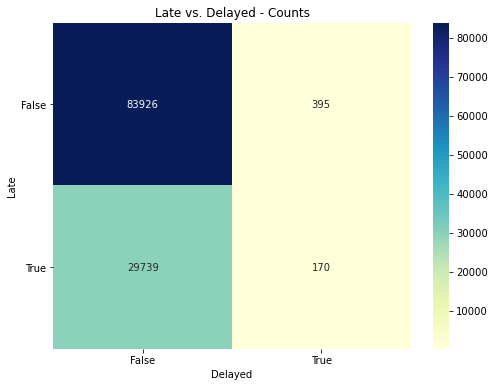

In [24]:
# Create a crosstab table
cross_table = pd.crosstab(df['isLte'], df['isDly'])

# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cross_table, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Delayed')
plt.ylabel('Late')
plt.title('Late vs. Delayed - Counts')
plt.xticks([0.5, 1.5], ['False', 'True'], rotation = 0)
plt.yticks([0.5, 1.5], ['False', 'True'], rotation = 0)
plt.show()

In [25]:
# Calculate the correlation between 'isLte' and 'isDly' columns
correlation = df['isLte'].corr(df['isDly'])

print("Correlation between isLte and isDly:", correlation)

Correlation between isLte and isDly: 0.00626300651870325


The cross table and Pearson correlation coefficient suggests to us that there is no linear relationship between the occurence of late trains and delayed trains in the dataset. We will return to these features later.

<div style="text-align:center; font-size: 18px; font-weight: bold;"> Feature Engineering (Nearby Traffic) </div>

In [26]:
df.head()

,station_id,line,predicted_time,arrival_time,wait_minutes,station_avg_wait,isLte,isSch,isFlt,isDly,station_name,destination_name,lat,long,free_flow_speed,current_speed
0,40260,G,2023-08-09 23:47:29,2023-08-09 23:51:29,4.0,8.394118,0,0,0,0,State/Lake,Harlem/Lake,41.87360,-87.62679,15,15
1,40260,Org,2023-08-09 23:47:41,2023-08-09 23:51:41,4.0,8.394118,0,0,0,0,State/Lake,Midway,41.87734,-87.63369,14,14
2,40260,Pink,2023-08-09 23:47:26,2023-08-09 23:54:26,7.0,8.394118,0,0,0,0,State/Lake,54th/Cermak,41.88574,-87.62758,11,11
3,40260,G,2023-08-09 23:47:39,2023-08-09 23:56:39,9.0,8.394118,0,0,0,0,State/Lake,Ashland/63rd,41.88436,-87.69232,21,21
4,40260,Org,2023-08-09 23:47:33,2023-08-10 00:06:33,19.0,8.394118,1,0,0,0,State/Lake,Midway,41.83957,-87.66485,65,65


Now we will take a look at the columns 'free_flow_speed' and 'current_speed', and engineer a new column from the two, titled 'nearby_traffic'.

Reminder: 

Per TomTom's Traffic Flow RESTful API:

**free_flow_speed** = "The free flow speed expected under ideal conditions, expressed in [MPH]

**current_speed** = "The current average speed at the selected [latitude and longitude], in [MPH]."

>Note that these speeds fetched from the TomTom API *do not* directly refer to the train itself; they are not train speeds. Rather, they are referring to the *traffic speeds* of the roads closest to the geographical coordinates of the specifc train.

By subtracting 'current_speed' from 'free_flow_speed', if we get any number other than 0, that indicates that there is some level of congestion in the nearby roads.

In [27]:
# Calculate the difference between 'free_flow_speed' and 'current_speed'
df['nearby_traffic'] = (df['free_flow_speed'] - df['current_speed']).apply(lambda x: 1 if x != 0 else 0)

df.sample(n = 5, random_state = 42)

,station_id,line,predicted_time,arrival_time,wait_minutes,station_avg_wait,isLte,isSch,isFlt,isDly,station_name,destination_name,lat,long,free_flow_speed,current_speed,nearby_traffic
49385,41440,Brn,2023-08-11 13:31:58,2023-08-11 14:00:58,29.0,24.412121,0,0,0,0,Addison,Kimball,41.87857,-87.62606,11,8,1
46796,40900,Red,2023-08-11 13:02:35,2023-08-11 13:09:35,7.0,7.472350,0,0,0,0,Howard,Howard,42.01906,-87.67289,16,16,0
67810,40220,Blue,2023-08-11 21:44:47,2023-08-11 21:52:47,8.0,10.280702,0,0,0,0,Western (Forest Park Branch),O'Hare,41.87162,-87.74425,63,63,0
24348,40280,G,2023-08-10 18:21:22,2023-08-10 18:32:22,11.0,22.356549,0,0,0,0,Central,Harlem/Lake,41.88435,-87.69251,21,21,0
98527,40310,Org,2023-08-19 17:52:01,2023-08-19 17:56:01,4.0,22.454054,0,0,0,0,Western,Loop,41.79986,-87.72453,20,20,0


'0' indicates no nearby road traffic, whereas '1' indicates that there is nearby traffic. Below shows the frequency of each in the dataset.

In [28]:
df['nearby_traffic'].value_counts()

0    59152
1    55078
Name: nearby_traffic, dtype: int64

In [29]:
# Create a DataFrame with all hours
hourly_traffic = pd.DataFrame({'hour_of_day': all_hours})

# Merge the original data with the all hours DataFrame to count traffic instances for each hour
hourly_traffic = hourly_traffic.merge(df.groupby(df['predicted_time'].dt.hour)['nearby_traffic'].sum().reset_index(), 
                                      how='left', left_on='hour_of_day', right_on='predicted_time')

# Fill NaN values with 0 (no traffic)
hourly_traffic['nearby_traffic'] = hourly_traffic['nearby_traffic'].fillna(0).astype(int)

# Drop the redundant 'predicted_time' column
hourly_traffic.drop(columns=['predicted_time'], inplace=True)

# Rename columns
hourly_traffic.columns = ['hour_of_day', 'instances_of_nearby_traffic']

# Print the new DataFrame
hourly_traffic

,hour_of_day,instances_of_nearby_traffic
0,0,180
1,1,125
2,2,7
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0


Here we look at the instances of nearby traffic per hour of day.

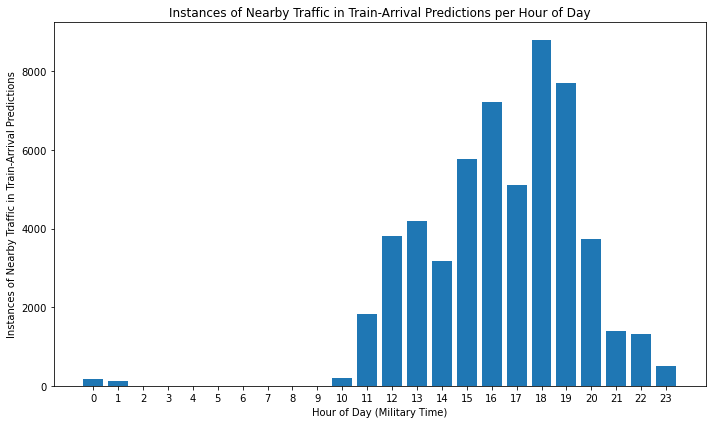

In [30]:
plt.figure(figsize=(10, 6))
plt.bar(hourly_traffic['hour_of_day'], hourly_traffic['instances_of_nearby_traffic'])
plt.xlabel('Hour of Day (Military Time)')
plt.ylabel('Instances of Nearby Traffic in Train-Arrival Predictions')
plt.title('Instances of Nearby Traffic in Train-Arrival Predictions per Hour of Day')
plt.xticks(all_hours)
plt.grid(False)
plt.tight_layout()
plt.show()

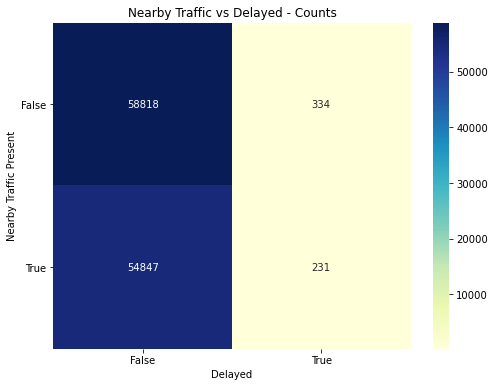

In [31]:
# Create a crosstab table
cross_table = pd.crosstab(df['nearby_traffic'], df['isDly'])

# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cross_table, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Delayed')
plt.ylabel('Nearby Traffic Present')
plt.title('Nearby Traffic vs Delayed - Counts')
plt.xticks([0.5, 1.5], ['False', 'True'], rotation = 0)
plt.yticks([0.5, 1.5], ['False', 'True'], rotation = 0)
plt.show()

In [32]:
# Calculate the correlation between 'isLte' and 'isDly' columns
correlation = df['nearby_traffic'].corr(df['isDly'])

print("Correlation between nearby_traffic and isDly:", correlation)

Correlation between nearby_traffic and isDly: -0.010344936512382429


The cross table and Pearson correlation coefficient suggests to us that there is no linear relationship between the occurence of nearby traffic and delayed trains in the dataset. We will return to these features later.

Here, we create a new column that indicates what hour of day the predictions were made at.

In [33]:
# Extract the hour from 'predicted_time' and create a new column 'hour_of_day'
df['hour_of_day'] = df['predicted_time'].dt.hour

df

,station_id,line,predicted_time,arrival_time,wait_minutes,station_avg_wait,isLte,isSch,isFlt,isDly,station_name,destination_name,lat,long,free_flow_speed,current_speed,nearby_traffic,hour_of_day
0,40260,G,2023-08-09 23:47:29,2023-08-09 23:51:29,4.0,8.394118,0,0,0,0,State/Lake,Harlem/Lake,41.87360,-87.62679,15,15,0,23
1,40260,Org,2023-08-09 23:47:41,2023-08-09 23:51:41,4.0,8.394118,0,0,0,0,State/Lake,Midway,41.87734,-87.63369,14,14,0,23
2,40260,Pink,2023-08-09 23:47:26,2023-08-09 23:54:26,7.0,8.394118,0,0,0,0,State/Lake,54th/Cermak,41.88574,-87.62758,11,11,0,23
3,40260,G,2023-08-09 23:47:39,2023-08-09 23:56:39,9.0,8.394118,0,0,0,0,State/Lake,Ashland/63rd,41.88436,-87.69232,21,21,0,23
4,40260,Org,2023-08-09 23:47:33,2023-08-10 00:06:33,19.0,8.394118,1,0,0,0,State/Lake,Midway,41.83957,-87.66485,65,65,0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114225,41090,Red,2023-09-01 12:22:36,2023-09-01 12:27:36,5.0,13.471345,0,0,0,0,Monroe,Howard,41.86740,-87.62740,24,17,1,12
114226,41090,Red,2023-09-01 12:22:38,2023-09-01 12:29:38,7.0,13.471345,0,0,0,0,Monroe,95th/Dan Ryan,41.90392,-87.63141,7,6,1,12
114227,41090,Red,2023-09-01 12:22:57,2023-09-01 12:35:57,13.0,13.471345,0,0,0,0,Monroe,Howard,41.81552,-87.63026,67,67,0,12
114228,41090,Red,2023-09-01 12:22:34,2023-09-01 12:38:34,16.0,13.471345,0,0,0,0,Monroe,95th/Dan Ryan,41.93739,-87.65332,14,8,1,12


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114230 entries, 0 to 114229
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   station_id        114230 non-null  int64         
 1   line              114230 non-null  object        
 2   predicted_time    114230 non-null  datetime64[ns]
 3   arrival_time      114230 non-null  datetime64[ns]
 4   wait_minutes      114230 non-null  float64       
 5   station_avg_wait  114230 non-null  float64       
 6   isLte             114230 non-null  int64         
 7   isSch             114230 non-null  int64         
 8   isFlt             114230 non-null  int64         
 9   isDly             114230 non-null  int64         
 10  station_name      114230 non-null  object        
 11  destination_name  114230 non-null  object        
 12  lat               114230 non-null  float64       
 13  long              114230 non-null  float64       
 14  free

<div style="text-align:center; font-size: 18px; font-weight: bold;"> Dropping Unwanted Columns Before Training the Model </div>

In [35]:
# List of columns to drop
columns_to_drop = ['isSch', 'isFlt', 'lat', 'long', 'station_name', 'destination_name', 'predicted_time', 'arrival_time']

# Drop the specified columns from the DataFrame
df2 = df.drop(columns=columns_to_drop)

df2

,station_id,line,wait_minutes,station_avg_wait,isLte,isDly,free_flow_speed,current_speed,nearby_traffic,hour_of_day
0,40260,G,4.0,8.394118,0,0,15,15,0,23
1,40260,Org,4.0,8.394118,0,0,14,14,0,23
2,40260,Pink,7.0,8.394118,0,0,11,11,0,23
3,40260,G,9.0,8.394118,0,0,21,21,0,23
4,40260,Org,19.0,8.394118,1,0,65,65,0,23
...,...,...,...,...,...,...,...,...,...,...
114225,41090,Red,5.0,13.471345,0,0,24,17,1,12
114226,41090,Red,7.0,13.471345,0,0,7,6,1,12
114227,41090,Red,13.0,13.471345,0,0,67,67,0,12
114228,41090,Red,16.0,13.471345,0,0,14,8,1,12


<div style="text-align:center; font-size: 24px; font-weight: bold;"> Training the Model </div>
<br style="line-height: 3px;">


### APPLY ENCODER

In [38]:
from sklearn.preprocessing import OneHotEncoder

# Create an instance of the OneHotEncoder
ohe = OneHotEncoder()

# Reshape the 'line' column to a 2D array-like structure
lines_reshaped = df2['line'].values.reshape(-1, 1)

# Fit and transform the OHE on the reshaped 'line' column
encoded_lines = ohe.fit_transform(lines_reshaped)

# Get the feature names for the encoded columns
encoded_feature_names = ohe.get_feature_names_out(['line'])

# Convert the encoded lines to a dense array and create a DataFrame
encoded_lines_df = pd.DataFrame(encoded_lines.toarray(), columns=encoded_feature_names)

# Concatenate the encoded lines DataFrame with the original DataFrame
df2 = pd.concat([df2, encoded_lines_df], axis=1)

# Drop the original 'line' column
df2.drop(['line'], axis=1, inplace=True)

KeyError: 'line'

In [39]:
df2.head()

,station_id,wait_minutes,station_avg_wait,isLte,isDly,free_flow_speed,current_speed,nearby_traffic,hour_of_day,line_Blue,line_Brn,line_G,line_Org,line_P,line_Pink,line_Red,line_Y
0,40260,4.0,8.394118,0,0,15,15,0,23,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,40260,4.0,8.394118,0,0,14,14,0,23,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,40260,7.0,8.394118,0,0,11,11,0,23,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,40260,9.0,8.394118,0,0,21,21,0,23,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,40260,19.0,8.394118,1,0,65,65,0,23,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [40]:
df2['isDly'].value_counts()

0    113665
1       565
Name: isDly, dtype: int64

In [41]:
# Define your features (X) and target variable (y)
X = df2.drop(['isDly'], axis = 1)  # Features
y = df2['isDly']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Now X_train and y_train are your training data, and X_test and y_test are your testing data

In [42]:
class_distribution = y_test.value_counts()
print(class_distribution)

0    22732
1      114
Name: isDly, dtype: int64


### SMOTE

In [43]:
# Instantiate the SMOTE resampler
smote = SMOTE(random_state=42)

# Resample the training data using SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [44]:
class_distribution = y_train_resampled.value_counts()
print(class_distribution)

1    90933
0    90933
Name: isDly, dtype: int64


### LOGISTIC REGRESSION

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Create an instance of the LogisticRegression model
logreg = LogisticRegression(random_state=42)

# Train the model on the resampled training data
logreg.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = logreg.predict(X_test)

# Evaluate the model's performance
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     22732
           1       0.00      1.00      0.01       114

    accuracy                           0.00     22846
   macro avg       0.00      0.50      0.00     22846
weighted avg       0.00      0.00      0.00     22846



C:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### RANDOM FOREST

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Instantiate the Random Forest classifier
rf_model = RandomForestClassifier(random_state = 42)

# Train the model on the resampled training set
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
rf_predictions = rf_model.predict(X_test)

# Evaluate the model on the test set
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)
rf_f1 = f1_score(y_test, rf_predictions)

print("Random Forest Test Set Accuracy:", rf_accuracy)
print("Random Forest Test Set Precision:", rf_precision)
print("Random Forest Test Set Recall:", rf_recall)
print("Random Forest Test Set F1-score:", rf_f1)



Random Forest Test Set Accuracy: 0.9903265341854154
Random Forest Test Set Precision: 0.05042016806722689
Random Forest Test Set Recall: 0.05263157894736842
Random Forest Test Set F1-score: 0.051502145922746774


In [47]:
# Get the feature importances
feature_importances_rf = rf_model.feature_importances_

# Create a DataFrame to display feature importances
importance_df_rf = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances_rf})

# Sort the DataFrame by importance in descending order
importance_df_rf = importance_df_rf.sort_values(by='Importance', ascending=False)

# Display the top most important features
print(importance_df_rf.head())

           Feature  Importance
4  free_flow_speed    0.103242
7      hour_of_day    0.100233
1     wait_minutes    0.099152
5    current_speed    0.095208
0       station_id    0.085231


### GRADIENT BOOSTING

In [48]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Instantiate the XGBoost classifier
xgb_model = XGBClassifier(random_state = 42)

# Fit the model on the resampled training data
xgb_model.fit(X_train_resampled, y_train_resampled)

# Predictions on the test set
xgb_predictions = xgb_model.predict(X_test)

# Evaluate the model on the test set
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
xgb_precision = precision_score(y_test, xgb_predictions)
xgb_recall = recall_score(y_test, xgb_predictions)
xgb_f1 = f1_score(y_test, xgb_predictions)

print("XGBoost Test Set Accuracy:", xgb_accuracy)
print("XGBoost Test Set Precision:", xgb_precision)
print("XGBoost Test Set Recall:", xgb_recall)
print("XGBoost Test Set F1-score:", xgb_f1)


XGBoost Test Set Accuracy: 0.9910268756018559
XGBoost Test Set Precision: 0.1111111111111111
XGBoost Test Set Recall: 0.11403508771929824
XGBoost Test Set F1-score: 0.11255411255411256


In [49]:
# Get the feature importances
feature_importances_xgb = xgb_model.feature_importances_

# Create a DataFrame to display feature importances
importance_df_xgb = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances_xgb})

# Sort the DataFrame by importance in descending order
importance_df_xgb = importance_df_xgb.sort_values(by='Importance', ascending=False)

# Display the top most important features
print(importance_df_xgb.head())

           Feature  Importance
13       line_Pink    0.180875
9         line_Brn    0.120278
6   nearby_traffic    0.092199
8        line_Blue    0.091500
14        line_Red    0.082124


### DECISION TREE

In [62]:
from sklearn.tree import DecisionTreeClassifier

# Create a binomial decision tree classifier
binomial_tree = DecisionTreeClassifier(random_state = 42)

# Train the decision tree on the training data
binomial_tree.fit(X_train_resampled, y_train_resampled)

# Get the feature importances
feature_importances = binomial_tree.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top most important features
print(importance_df.head(10))

             Feature  Importance
7        hour_of_day    0.119198
4    free_flow_speed    0.117113
2   station_avg_wait    0.092699
1       wait_minutes    0.090167
5      current_speed    0.088702
6     nearby_traffic    0.077073
0         station_id    0.068111
14          line_Red    0.058729
10            line_G    0.051009
8          line_Blue    0.046670


In [63]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test set
binomial_tree_predictions = binomial_tree.predict(X_test)

# Calculate accuracy
binomial_tree_accuracy = accuracy_score(y_test, binomial_tree_predictions)

# Calculate precision
binomial_tree_precision = precision_score(y_test, binomial_tree_predictions)

# Calculate recall
binomial_tree_recall = recall_score(y_test, binomial_tree_predictions)

# Calculate F1-score
binomial_tree_f1_score = f1_score(y_test, binomial_tree_predictions)

# Display the evaluation metrics
print("Binomial Decision Tree Test Set Accuracy:", binomial_tree_accuracy)
print("Binomial Decision Tree Test Set Precision:", binomial_tree_precision)
print("Binomial Decision Tree Test Set Recall:", binomial_tree_recall)
print("Binomial Decision Tree Test Set F1-score:", binomial_tree_f1_score)

Binomial Decision Tree Test Set Accuracy: 0.9856867723014969
Binomial Decision Tree Test Set Precision: 0.08560311284046693
Binomial Decision Tree Test Set Recall: 0.19298245614035087
Binomial Decision Tree Test Set F1-score: 0.11859838274932617


### TPOT

In [54]:
from tpot import TPOTClassifier

In [55]:
tpot = TPOTClassifier(
    generations = 5,  # Number of iterations or generations for the search
    population_size = 20,  # Number of individuals in each generation
    verbosity = 2,  # Control the level of detail in the output
    random_state = 42,  # Seed for reproducibility
    config_dict = 'TPOT sparse'  # Use a predefined configuration for sparse data
)

In [56]:
tpot.fit(X_train_resampled, y_train_resampled)


Generation 1 - Current best internal CV score: 0.9951008248932837

Generation 2 - Current best internal CV score: 0.995183299422299

Generation 3 - Current best internal CV score: 0.995183299422299

Generation 4 - Current best internal CV score: 0.9951887998204294

Generation 5 - Current best internal CV score: 0.9951887998204294

Best pipeline: XGBClassifier(input_matrix, learning_rate=1.0, max_depth=6, min_child_weight=14, n_estimators=100, n_jobs=1, subsample=0.4, verbosity=0)


TPOTClassifier(config_dict='TPOT sparse', generations=5, population_size=20,
               random_state=42, verbosity=2)

In [57]:
best_pipeline = tpot.fitted_pipeline_

In [58]:
# Create an instance of XGBClassifier with the best hyperparameters
best_xgb_classifier = XGBClassifier(
    learning_rate = 1.0,
    max_depth = 6,
    min_child_weight = 14,
    n_estimators = 100,
    n_jobs = 1,
    subsample = 0.4,
    verbosity = 0
)

In [59]:
# Fit the classifier to the resampled training data
best_xgb_classifier.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=1.0, max_delta_step=0, max_depth=6,
              min_child_weight=14, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.4,
              tree_method='exact', validate_parameters=1, verbosity=0)

In [60]:
# Make predictions on the test data
y_pred = best_xgb_classifier.predict(X_test)

In [64]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.99
Precision: 0.08
Recall: 0.09
F1-score: 0.09
